In [2]:
#This tutorial is following the Titanic dataquest example:
#https://www.dataquest.io/mission/74/getting-started-with-kaggle
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import numpy as np

In [3]:
#This is a dataframe
titanic = pd.read_csv("train.csv")
print 'HEAD'
print(titanic.head(5))
print '\nDESCRIBE'
print(titanic.describe())

HEAD
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
#count is the number of entries. We can see though that age only has 714. Fill in missing entries with median age.
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

In [5]:
#Need to convert non-numeric entries to numeric entries - see all unique entries
print(titanic["Sex"].unique())
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


In [6]:
#Do the same for embarked
print(titanic["Embarked"].unique())

['S' 'C' 'Q' nan]


In [7]:
titanic["Embarked"].fillna(0, inplace=True)
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

In [8]:
#Feature engineering - create new columns that will aid our analysis
#For example, we know that on the Titanic, Women + Children got precidence. Create a field with them.
MaxChildAge = 13
titanic["WomenChildren"] = titanic["Sex"]
titanic.loc[titanic["Age"] < MaxChildAge, "WomenChildren"] = 1
titanic["Fare/Class"] = titanic["Fare"]/titanic["Pclass"]

#how to print multiple columns a dataframe. Weird syntax...
#print(titanic.ix[:,["Age","Sex","WomenChildren"]])

In [9]:
#########PART 2#########
#Now let's get to some machine learning! This section shows many different algorithms
#########PART 2#########
print(titanic.columns)
#survival        Survival
#                (0 = No; 1 = Yes)
#pclass          Passenger Class
#                (1 = 1st; 2 = 2nd; 3 = 3rd)
#name            Name
#sex             Sex
#age             Age
#sibsp           Number of Siblings/Spouses Aboard
#parch           Number of Parents/Children Aboard
#ticket          Ticket Number
#fare            Passenger Fare
#cabin           Cabin
#embarked        Port of Embarkation
#                (C = Cherbourg; Q = Queenstown; S = Southampton)

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'WomenChildren', u'Fare/Class'],
      dtype='object')


In [10]:
#Let's create the different items we want for the Linear Regression

#feature_cols = ['Age','Sex','Fare','Pclass','Embarked','SibSp','Parch']
feature_cols = ["WomenChildren","Pclass","Fare","Sex"]
# use the list to select a subset of the DataFrame (X)
Y = titanic.Survived
lm = LinearRegression()

In [11]:
#We can try various plotting things if we want
#%matplotlib inline
#sns.pairplot(titanic, x_vars=['WomenChildren'], y_vars='Survived', size=7, aspect=0.7)

In [12]:
#cross_val_score computes a linear regression on X, Y using cv folds for the cross validation phase.
#MSE = 1/n sum(Y_pred - Y_actual) = lower the better
for i in xrange(1,len(feature_cols)):
    X = titanic[feature_cols[0:i]]
    CVS = np.sqrt(-cross_val_score(lm, X, Y, cv=10, scoring='mean_squared_error'))
    print(i,CVS.mean(),CVS.std()*2)

(1, 0.40200802086586834, 0.061115603207262038)
(2, 0.37839825162555035, 0.044163523601727046)
(3, 0.37908717213242171, 0.043991532999219665)


In [13]:
#Instead of a particular scoring method (e.g. MSE), we can just print the fraction of times the alg
#correctly predicted the Survivability of a passenger. 
#Logistic Reg maps linear reg values to 0/1, making it easy to compare to passenger survivability (0/1 also)
from sklearn.linear_model import LogisticRegression
alg = LogisticRegression(random_state=1)
scores = cross_val_score(alg, X, Y, cv=10)
print(scores.mean())

0.792354159573


(0.80389125799573569, 0.020675122697521465)


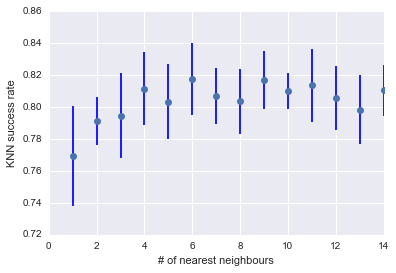

In [17]:
#Try a K-nearest neighbour algorithm? Need to make a train subset and a test subset from the training data
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline
nn = np.arange(1,15)                          #Number of nearest neighbours for the KNN alg.
N_scores = len(nn)
knn_avg_score = np.zeros(N_scores)
knn_std = np.zeros(N_scores)
N_avg = 15
L = 7*len(titanic.Fare)/10                #Ratio of train/test data set size

for i in xrange(0,N_scores):
    scores = np.zeros(N_avg)
    for j in xrange(0,N_avg):
        #first make a copy and randomize the entries (already randomized but for completeness)
        titanic_copy = titanic.copy()
        titanic_copy = titanic_copy.reindex(np.random.permutation(titanic_copy.index))
        #split into two equal data frames
        df1, df2 = np.array_split(titanic_copy, [L])
        #Now train the KNN on df1, and then test on df2
        #weight=distance: weights points by inverse of their distance. Closer neighbors of a query point = greater influence 
        knn = KNeighborsClassifier(n_neighbors=nn[i], weights="distance")
        knn.fit(df1[feature_cols], df1["Survived"])
        knn_predict = knn.predict(df2[feature_cols]) - df2["Survived"]
        scores[j] = len(knn_predict.loc[knn_predict == 0])/float(len(df2))
    knn_avg_score[i] = np.mean(scores)
    knn_std[i] = np.std(scores)
plt.plot(nn,knn_avg_score,'o', label='data')
plt.ylabel("KNN success rate")
plt.xlabel("# of nearest neighbours")
plt.errorbar(nn,knn_avg_score, yerr=knn_std, linestyle='None', color='b',label='')
print(np.mean(knn_avg_score), np.mean(knn_std))

In [18]:
#########PART 3#########
#Now that we have built a model on the training data, we test our model on the test data with the best alg of choice.
#Need to prep it in the same way though!
#########PART 3#########

In [19]:
titanic_test = pd.read_csv("test.csv")

In [20]:
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic["Embarked"].fillna(0, inplace=True)
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic["Fare"].median())
titanic_test["WomenChildren"] = titanic_test["Sex"]
titanic_test.loc[titanic_test["Age"] < MaxChildAge, "WomenChildren"] = 1

In [21]:
#now make the new predictions on the test data (i.e. a dataset completely unseen by the linear regression)
#The test data has no "Survived" column (i.e. no way to check our answer), so we submit it to Kaggle to check.

#Logistic Regression - scored 0.77 - best submission so far
alg = LogisticRegression(random_state=1)
alg.fit(titanic[feature_cols], titanic["Survived"])
#predictions = alg.predict(titanic_test[feature_cols])

#try KNN instead - scored 0.746
knn = KNeighborsClassifier(n_neighbors=6, weights="distance")
knn.fit(titanic[feature_cols], titanic["Survived"])
predictions = knn.predict(titanic_test[feature_cols])

In [22]:
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

#Submission to Kaggle
submission.to_csv("Titanic_Kaggle_Submission.csv", index=False)